In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
torch.__version__

'1.6.0'

In [3]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [4]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [5]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [6]:
torch.cuda.device_count()

2

In [7]:
EPOCHS = 20
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = 1e-3 
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 128 Learning rate: 0.001


In [8]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [9]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [10]:
#data_diffr = np.load('../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load('../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

In [11]:
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [12]:
try:
    data_diffr = np.load('../data/20191008_39_diff.npz')['arr_0']
    data_diffr_red = np.load('../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    print(data_diffr.shape)
    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])
    np.savez_compressed('../data/20191008_39_diff_reduced.npz', data_diffr_red)

In [13]:
data_diffr_red = np.log(data_diffr_red + 1.0)

In [14]:
data_diffr.shape, data_diffr_red.shape

((161, 161, 256, 256), (161, 161, 64, 64))

In [15]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [16]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [17]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [18]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [19]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [20]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([128, 1, 64, 64])


/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64])
torch.float32 torch.float32


In [21]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 32, 64, 64]          320
|    └─ReLU: 2-2                         [-1, 32, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 32, 64, 64]          9,248
|    └─ReLU: 2-4                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-7                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-8                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-9                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-10                   [-1, 64, 16, 16]          --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-12                        [-1, 128, 16, 16]         --

In [22]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()#
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR / 10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 720.0 which is every 6 epochs


In [23]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

**For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks**

In [24]:
scaler = torch.cuda.amp.GradScaler()

In [25]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
        
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [26]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [28]:

for epoch in range (60):#EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

120it [00:17,  6.98it/s]


Saving improved model after Val Loss improved from 0.44651 to 0.43198
Epoch: 0 | FT  | Train Loss: 0.35606 | Val Loss: 0.43198
Epoch: 0 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 0 | Ph  | Train Loss: 0.349 | Val Loss: 0.424
Epoch: 0 | Ending LR: 0.000325 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.43198 to 0.41886
Epoch: 1 | FT  | Train Loss: 0.34427 | Val Loss: 0.41886
Epoch: 1 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 1 | Ph  | Train Loss: 0.338 | Val Loss: 0.411
Epoch: 1 | Ending LR: 0.000250 


120it [00:17,  7.05it/s]


Saving improved model after Val Loss improved from 0.41886 to 0.41168
Epoch: 2 | FT  | Train Loss: 0.33090 | Val Loss: 0.41168
Epoch: 2 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 2 | Ph  | Train Loss: 0.324 | Val Loss: 0.404
Epoch: 2 | Ending LR: 0.000175 


120it [00:17,  6.99it/s]


Saving improved model after Val Loss improved from 0.41168 to 0.40701
Epoch: 3 | FT  | Train Loss: 0.31978 | Val Loss: 0.40701
Epoch: 3 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 3 | Ph  | Train Loss: 0.313 | Val Loss: 0.399
Epoch: 3 | Ending LR: 0.000100 


120it [00:17,  7.05it/s]


Saving improved model after Val Loss improved from 0.40701 to 0.39895
Epoch: 4 | FT  | Train Loss: 0.31421 | Val Loss: 0.39895
Epoch: 4 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 4 | Ph  | Train Loss: 0.308 | Val Loss: 0.391
Epoch: 4 | Ending LR: 0.000138 


120it [00:17,  6.99it/s]


Saving improved model after Val Loss improved from 0.39895 to 0.39812
Epoch: 5 | FT  | Train Loss: 0.31344 | Val Loss: 0.39812
Epoch: 5 | Amp | Train Loss: 0.0066 | Val Loss: 0.0077
Epoch: 5 | Ph  | Train Loss: 0.307 | Val Loss: 0.390
Epoch: 5 | Ending LR: 0.000175 


120it [00:17,  7.01it/s]


Epoch: 6 | FT  | Train Loss: 0.31064 | Val Loss: 0.40899
Epoch: 6 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 6 | Ph  | Train Loss: 0.304 | Val Loss: 0.401
Epoch: 6 | Ending LR: 0.000213 


120it [00:17,  6.97it/s]


Epoch: 7 | FT  | Train Loss: 0.30836 | Val Loss: 0.40626
Epoch: 7 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 7 | Ph  | Train Loss: 0.302 | Val Loss: 0.398
Epoch: 7 | Ending LR: 0.000250 


120it [00:17,  7.05it/s]


Saving improved model after Val Loss improved from 0.39812 to 0.38835
Epoch: 8 | FT  | Train Loss: 0.30631 | Val Loss: 0.38835
Epoch: 8 | Amp | Train Loss: 0.0066 | Val Loss: 0.0077
Epoch: 8 | Ph  | Train Loss: 0.300 | Val Loss: 0.381
Epoch: 8 | Ending LR: 0.000287 


120it [00:17,  6.99it/s]


Epoch: 9 | FT  | Train Loss: 0.30234 | Val Loss: 0.39469
Epoch: 9 | Amp | Train Loss: 0.0066 | Val Loss: 0.0077
Epoch: 9 | Ph  | Train Loss: 0.296 | Val Loss: 0.387
Epoch: 9 | Ending LR: 0.000325 


120it [00:16,  7.10it/s]


Saving improved model after Val Loss improved from 0.38835 to 0.38488
Epoch: 10 | FT  | Train Loss: 0.29783 | Val Loss: 0.38488
Epoch: 10 | Amp | Train Loss: 0.0065 | Val Loss: 0.0077
Epoch: 10 | Ph  | Train Loss: 0.291 | Val Loss: 0.377
Epoch: 10 | Ending LR: 0.000287 


120it [00:16,  7.07it/s]


Saving improved model after Val Loss improved from 0.38488 to 0.37832
Epoch: 11 | FT  | Train Loss: 0.28688 | Val Loss: 0.37832
Epoch: 11 | Amp | Train Loss: 0.0065 | Val Loss: 0.0077
Epoch: 11 | Ph  | Train Loss: 0.280 | Val Loss: 0.371
Epoch: 11 | Ending LR: 0.000250 


120it [00:16,  7.07it/s]


Saving improved model after Val Loss improved from 0.37832 to 0.37627
Epoch: 12 | FT  | Train Loss: 0.28170 | Val Loss: 0.37627
Epoch: 12 | Amp | Train Loss: 0.0065 | Val Loss: 0.0076
Epoch: 12 | Ph  | Train Loss: 0.275 | Val Loss: 0.369
Epoch: 12 | Ending LR: 0.000213 


120it [00:17,  7.06it/s]


Saving improved model after Val Loss improved from 0.37627 to 0.36552
Epoch: 13 | FT  | Train Loss: 0.27421 | Val Loss: 0.36552
Epoch: 13 | Amp | Train Loss: 0.0064 | Val Loss: 0.0076
Epoch: 13 | Ph  | Train Loss: 0.268 | Val Loss: 0.358
Epoch: 13 | Ending LR: 0.000175 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.36552 to 0.36024
Epoch: 14 | FT  | Train Loss: 0.26678 | Val Loss: 0.36024
Epoch: 14 | Amp | Train Loss: 0.0064 | Val Loss: 0.0076
Epoch: 14 | Ph  | Train Loss: 0.260 | Val Loss: 0.353
Epoch: 14 | Ending LR: 0.000138 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.36024 to 0.35723
Epoch: 15 | FT  | Train Loss: 0.26224 | Val Loss: 0.35723
Epoch: 15 | Amp | Train Loss: 0.0064 | Val Loss: 0.0076
Epoch: 15 | Ph  | Train Loss: 0.256 | Val Loss: 0.350
Epoch: 15 | Ending LR: 0.000100 


120it [00:17,  7.06it/s]


Epoch: 16 | FT  | Train Loss: 0.25838 | Val Loss: 0.35873
Epoch: 16 | Amp | Train Loss: 0.0064 | Val Loss: 0.0076
Epoch: 16 | Ph  | Train Loss: 0.252 | Val Loss: 0.351
Epoch: 16 | Ending LR: 0.000119 


120it [00:17,  7.02it/s]


Epoch: 17 | FT  | Train Loss: 0.25769 | Val Loss: 0.36114
Epoch: 17 | Amp | Train Loss: 0.0064 | Val Loss: 0.0076
Epoch: 17 | Ph  | Train Loss: 0.251 | Val Loss: 0.354
Epoch: 17 | Ending LR: 0.000137 


120it [00:17,  7.03it/s]


Epoch: 18 | FT  | Train Loss: 0.25685 | Val Loss: 0.36454
Epoch: 18 | Amp | Train Loss: 0.0064 | Val Loss: 0.0076
Epoch: 18 | Ph  | Train Loss: 0.250 | Val Loss: 0.357
Epoch: 18 | Ending LR: 0.000156 


120it [00:16,  7.06it/s]


Saving improved model after Val Loss improved from 0.35723 to 0.35549
Epoch: 19 | FT  | Train Loss: 0.25773 | Val Loss: 0.35549
Epoch: 19 | Amp | Train Loss: 0.0064 | Val Loss: 0.0075
Epoch: 19 | Ph  | Train Loss: 0.251 | Val Loss: 0.348
Epoch: 19 | Ending LR: 0.000175 


120it [00:16,  7.07it/s]


Epoch: 20 | FT  | Train Loss: 0.25543 | Val Loss: 0.36000
Epoch: 20 | Amp | Train Loss: 0.0063 | Val Loss: 0.0075
Epoch: 20 | Ph  | Train Loss: 0.249 | Val Loss: 0.352
Epoch: 20 | Ending LR: 0.000194 


120it [00:17,  7.04it/s]


Epoch: 21 | FT  | Train Loss: 0.25418 | Val Loss: 0.36026
Epoch: 21 | Amp | Train Loss: 0.0064 | Val Loss: 0.0076
Epoch: 21 | Ph  | Train Loss: 0.248 | Val Loss: 0.353
Epoch: 21 | Ending LR: 0.000213 


120it [00:17,  6.98it/s]


Epoch: 22 | FT  | Train Loss: 0.25131 | Val Loss: 0.35918
Epoch: 22 | Amp | Train Loss: 0.0063 | Val Loss: 0.0076
Epoch: 22 | Ph  | Train Loss: 0.245 | Val Loss: 0.352
Epoch: 22 | Ending LR: 0.000194 


120it [00:17,  7.02it/s]


Saving improved model after Val Loss improved from 0.35549 to 0.35157
Epoch: 23 | FT  | Train Loss: 0.24663 | Val Loss: 0.35157
Epoch: 23 | Amp | Train Loss: 0.0063 | Val Loss: 0.0075
Epoch: 23 | Ph  | Train Loss: 0.240 | Val Loss: 0.344
Epoch: 23 | Ending LR: 0.000175 


120it [00:17,  6.97it/s]


Saving improved model after Val Loss improved from 0.35157 to 0.34697
Epoch: 24 | FT  | Train Loss: 0.24171 | Val Loss: 0.34697
Epoch: 24 | Amp | Train Loss: 0.0063 | Val Loss: 0.0075
Epoch: 24 | Ph  | Train Loss: 0.235 | Val Loss: 0.339
Epoch: 24 | Ending LR: 0.000156 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.34697 to 0.34222
Epoch: 25 | FT  | Train Loss: 0.23775 | Val Loss: 0.34222
Epoch: 25 | Amp | Train Loss: 0.0063 | Val Loss: 0.0075
Epoch: 25 | Ph  | Train Loss: 0.231 | Val Loss: 0.335
Epoch: 25 | Ending LR: 0.000137 


120it [00:17,  7.01it/s]


Saving improved model after Val Loss improved from 0.34222 to 0.34056
Epoch: 26 | FT  | Train Loss: 0.23487 | Val Loss: 0.34056
Epoch: 26 | Amp | Train Loss: 0.0063 | Val Loss: 0.0075
Epoch: 26 | Ph  | Train Loss: 0.229 | Val Loss: 0.333
Epoch: 26 | Ending LR: 0.000119 


120it [00:17,  7.05it/s]


Saving improved model after Val Loss improved from 0.34056 to 0.33567
Epoch: 27 | FT  | Train Loss: 0.23154 | Val Loss: 0.33567
Epoch: 27 | Amp | Train Loss: 0.0063 | Val Loss: 0.0075
Epoch: 27 | Ph  | Train Loss: 0.225 | Val Loss: 0.328
Epoch: 27 | Ending LR: 0.000100 


120it [00:17,  7.04it/s]


Epoch: 28 | FT  | Train Loss: 0.22974 | Val Loss: 0.33925
Epoch: 28 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 28 | Ph  | Train Loss: 0.223 | Val Loss: 0.332
Epoch: 28 | Ending LR: 0.000109 


120it [00:17,  7.04it/s]


Epoch: 29 | FT  | Train Loss: 0.22895 | Val Loss: 0.33750
Epoch: 29 | Amp | Train Loss: 0.0062 | Val Loss: 0.0075
Epoch: 29 | Ph  | Train Loss: 0.223 | Val Loss: 0.330
Epoch: 29 | Ending LR: 0.000119 


120it [00:17,  6.99it/s]


Epoch: 30 | FT  | Train Loss: 0.22800 | Val Loss: 0.34059
Epoch: 30 | Amp | Train Loss: 0.0062 | Val Loss: 0.0075
Epoch: 30 | Ph  | Train Loss: 0.222 | Val Loss: 0.333
Epoch: 30 | Ending LR: 0.000128 


120it [00:17,  7.00it/s]


Epoch: 31 | FT  | Train Loss: 0.22880 | Val Loss: 0.34087
Epoch: 31 | Amp | Train Loss: 0.0062 | Val Loss: 0.0075
Epoch: 31 | Ph  | Train Loss: 0.223 | Val Loss: 0.333
Epoch: 31 | Ending LR: 0.000137 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.33567 to 0.33443
Epoch: 32 | FT  | Train Loss: 0.22680 | Val Loss: 0.33443
Epoch: 32 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 32 | Ph  | Train Loss: 0.221 | Val Loss: 0.327
Epoch: 32 | Ending LR: 0.000147 


120it [00:17,  6.98it/s]


Epoch: 33 | FT  | Train Loss: 0.22693 | Val Loss: 0.33920
Epoch: 33 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 33 | Ph  | Train Loss: 0.221 | Val Loss: 0.332
Epoch: 33 | Ending LR: 0.000156 


120it [00:17,  6.98it/s]


Saving improved model after Val Loss improved from 0.33443 to 0.33072
Epoch: 34 | FT  | Train Loss: 0.22393 | Val Loss: 0.33072
Epoch: 34 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 34 | Ph  | Train Loss: 0.218 | Val Loss: 0.323
Epoch: 34 | Ending LR: 0.000147 


120it [00:17,  7.03it/s]


Epoch: 35 | FT  | Train Loss: 0.22262 | Val Loss: 0.33395
Epoch: 35 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 35 | Ph  | Train Loss: 0.216 | Val Loss: 0.327
Epoch: 35 | Ending LR: 0.000137 


120it [00:16,  7.06it/s]


Epoch: 36 | FT  | Train Loss: 0.21985 | Val Loss: 0.33587
Epoch: 36 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 36 | Ph  | Train Loss: 0.214 | Val Loss: 0.328
Epoch: 36 | Ending LR: 0.000128 


120it [00:17,  7.02it/s]


Saving improved model after Val Loss improved from 0.33072 to 0.32652
Epoch: 37 | FT  | Train Loss: 0.21694 | Val Loss: 0.32652
Epoch: 37 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 37 | Ph  | Train Loss: 0.211 | Val Loss: 0.319
Epoch: 37 | Ending LR: 0.000119 


120it [00:17,  6.97it/s]


Epoch: 38 | FT  | Train Loss: 0.21509 | Val Loss: 0.32903
Epoch: 38 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 38 | Ph  | Train Loss: 0.209 | Val Loss: 0.322
Epoch: 38 | Ending LR: 0.000109 


120it [00:17,  7.04it/s]


Epoch: 39 | FT  | Train Loss: 0.21347 | Val Loss: 0.32659
Epoch: 39 | Amp | Train Loss: 0.0062 | Val Loss: 0.0074
Epoch: 39 | Ph  | Train Loss: 0.207 | Val Loss: 0.319
Epoch: 39 | Ending LR: 0.000100 


120it [00:17,  7.06it/s]


Epoch: 40 | FT  | Train Loss: 0.21209 | Val Loss: 0.32926
Epoch: 40 | Amp | Train Loss: 0.0061 | Val Loss: 0.0074
Epoch: 40 | Ph  | Train Loss: 0.206 | Val Loss: 0.322
Epoch: 40 | Ending LR: 0.000105 


120it [00:17,  7.01it/s]


Saving improved model after Val Loss improved from 0.32652 to 0.32588
Epoch: 41 | FT  | Train Loss: 0.21127 | Val Loss: 0.32588
Epoch: 41 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 41 | Ph  | Train Loss: 0.205 | Val Loss: 0.319
Epoch: 41 | Ending LR: 0.000109 


120it [00:17,  6.99it/s]


Saving improved model after Val Loss improved from 0.32588 to 0.32273
Epoch: 42 | FT  | Train Loss: 0.21010 | Val Loss: 0.32273
Epoch: 42 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 42 | Ph  | Train Loss: 0.204 | Val Loss: 0.315
Epoch: 42 | Ending LR: 0.000114 


120it [00:17,  6.97it/s]


Epoch: 43 | FT  | Train Loss: 0.20964 | Val Loss: 0.32893
Epoch: 43 | Amp | Train Loss: 0.0061 | Val Loss: 0.0074
Epoch: 43 | Ph  | Train Loss: 0.204 | Val Loss: 0.322
Epoch: 43 | Ending LR: 0.000119 


120it [00:17,  7.05it/s]


Epoch: 44 | FT  | Train Loss: 0.20915 | Val Loss: 0.32485
Epoch: 44 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 44 | Ph  | Train Loss: 0.203 | Val Loss: 0.317
Epoch: 44 | Ending LR: 0.000123 


120it [00:17,  7.02it/s]


Epoch: 45 | FT  | Train Loss: 0.20887 | Val Loss: 0.32825
Epoch: 45 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 45 | Ph  | Train Loss: 0.203 | Val Loss: 0.321
Epoch: 45 | Ending LR: 0.000128 


120it [00:17,  7.04it/s]


Saving improved model after Val Loss improved from 0.32273 to 0.32187
Epoch: 46 | FT  | Train Loss: 0.20773 | Val Loss: 0.32187
Epoch: 46 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 46 | Ph  | Train Loss: 0.202 | Val Loss: 0.315
Epoch: 46 | Ending LR: 0.000123 


120it [00:17,  7.01it/s]


Epoch: 47 | FT  | Train Loss: 0.20591 | Val Loss: 0.32424
Epoch: 47 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 47 | Ph  | Train Loss: 0.200 | Val Loss: 0.317
Epoch: 47 | Ending LR: 0.000119 


120it [00:17,  7.05it/s]


Epoch: 48 | FT  | Train Loss: 0.20405 | Val Loss: 0.32479
Epoch: 48 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 48 | Ph  | Train Loss: 0.198 | Val Loss: 0.317
Epoch: 48 | Ending LR: 0.000114 


120it [00:17,  7.04it/s]


Epoch: 49 | FT  | Train Loss: 0.20311 | Val Loss: 0.32258
Epoch: 49 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 49 | Ph  | Train Loss: 0.197 | Val Loss: 0.315
Epoch: 49 | Ending LR: 0.000109 


120it [00:17,  7.02it/s]


Epoch: 50 | FT  | Train Loss: 0.20157 | Val Loss: 0.32433
Epoch: 50 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 50 | Ph  | Train Loss: 0.195 | Val Loss: 0.317
Epoch: 50 | Ending LR: 0.000105 


120it [00:17,  7.02it/s]


Saving improved model after Val Loss improved from 0.32187 to 0.32018
Epoch: 51 | FT  | Train Loss: 0.20028 | Val Loss: 0.32018
Epoch: 51 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 51 | Ph  | Train Loss: 0.194 | Val Loss: 0.313
Epoch: 51 | Ending LR: 0.000100 


120it [00:17,  7.02it/s]


Saving improved model after Val Loss improved from 0.32018 to 0.31946
Epoch: 52 | FT  | Train Loss: 0.19950 | Val Loss: 0.31946
Epoch: 52 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 52 | Ph  | Train Loss: 0.193 | Val Loss: 0.312
Epoch: 52 | Ending LR: 0.000102 


120it [00:17,  7.03it/s]


Epoch: 53 | FT  | Train Loss: 0.19818 | Val Loss: 0.31983
Epoch: 53 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 53 | Ph  | Train Loss: 0.192 | Val Loss: 0.313
Epoch: 53 | Ending LR: 0.000105 


120it [00:17,  7.03it/s]


Saving improved model after Val Loss improved from 0.31946 to 0.31625
Epoch: 54 | FT  | Train Loss: 0.19791 | Val Loss: 0.31625
Epoch: 54 | Amp | Train Loss: 0.0061 | Val Loss: 0.0072
Epoch: 54 | Ph  | Train Loss: 0.192 | Val Loss: 0.309
Epoch: 54 | Ending LR: 0.000107 


120it [00:17,  6.94it/s]


Epoch: 55 | FT  | Train Loss: 0.19713 | Val Loss: 0.31932
Epoch: 55 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 55 | Ph  | Train Loss: 0.191 | Val Loss: 0.312
Epoch: 55 | Ending LR: 0.000109 


120it [00:17,  6.90it/s]


Epoch: 56 | FT  | Train Loss: 0.19697 | Val Loss: 0.31877
Epoch: 56 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 56 | Ph  | Train Loss: 0.191 | Val Loss: 0.311
Epoch: 56 | Ending LR: 0.000112 


120it [00:17,  6.91it/s]


Epoch: 57 | FT  | Train Loss: 0.19597 | Val Loss: 0.32164
Epoch: 57 | Amp | Train Loss: 0.0061 | Val Loss: 0.0073
Epoch: 57 | Ph  | Train Loss: 0.190 | Val Loss: 0.314
Epoch: 57 | Ending LR: 0.000114 


120it [00:17,  6.94it/s]


Epoch: 58 | FT  | Train Loss: 0.19563 | Val Loss: 0.31770
Epoch: 58 | Amp | Train Loss: 0.0060 | Val Loss: 0.0073
Epoch: 58 | Ph  | Train Loss: 0.190 | Val Loss: 0.310
Epoch: 58 | Ending LR: 0.000112 


120it [00:17,  6.82it/s]


Epoch: 59 | FT  | Train Loss: 0.19433 | Val Loss: 0.31901
Epoch: 59 | Amp | Train Loss: 0.0060 | Val Loss: 0.0073
Epoch: 59 | Ph  | Train Loss: 0.188 | Val Loss: 0.312
Epoch: 59 | Ending LR: 0.000109 


Text(0.5, 0, 'Epoch')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


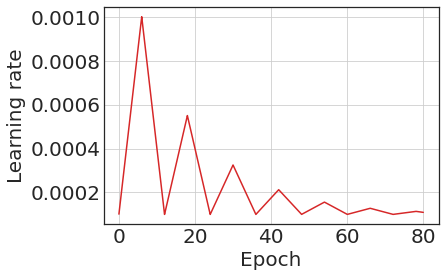

In [29]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

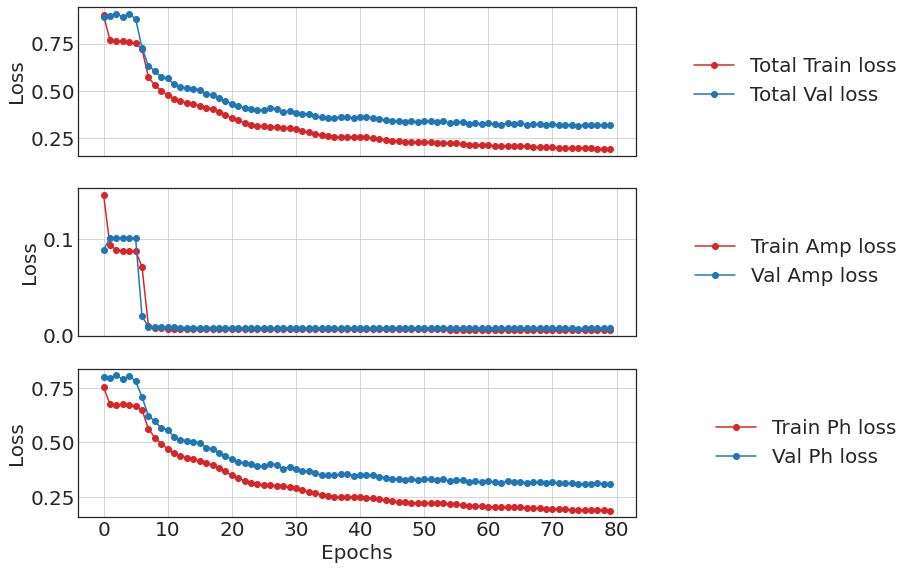

In [44]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [45]:
model.eval() #imp when have dropout etc
amps_eval = []
phs_eval = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_eval.append(amp_eval[j].detach().to("cpu").numpy())
        phs_eval.append(ph_eval[j].detach().to("cpu").numpy())

/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [46]:
amps_eval = np.array(amps_eval).squeeze()
phs_eval = np.array(phs_eval).squeeze()
print(amps_eval.shape, amps_eval.dtype)
print(phs_eval.shape, phs_eval.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

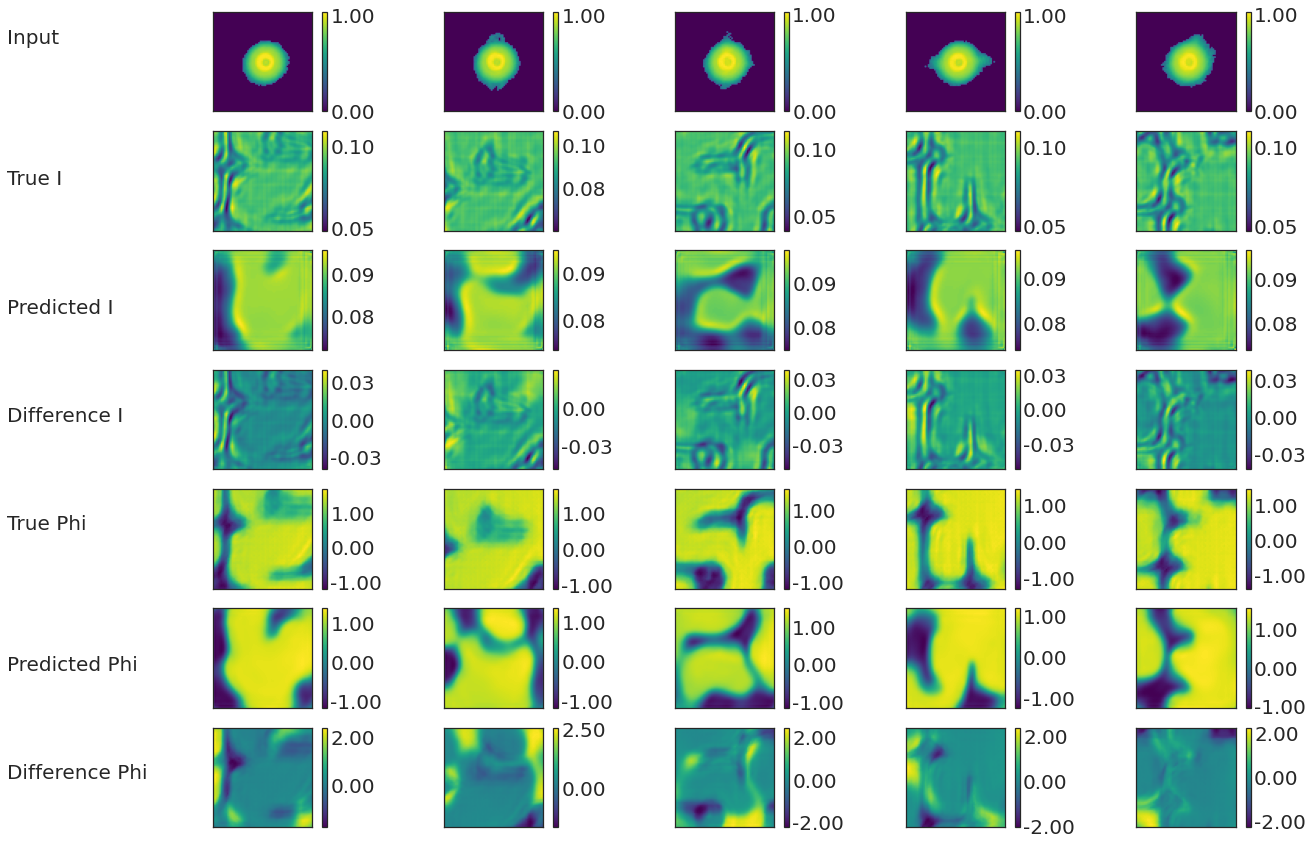

In [47]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [48]:
point_size = 3
overlap = 4*point_size

In [49]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [50]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [51]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [52]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

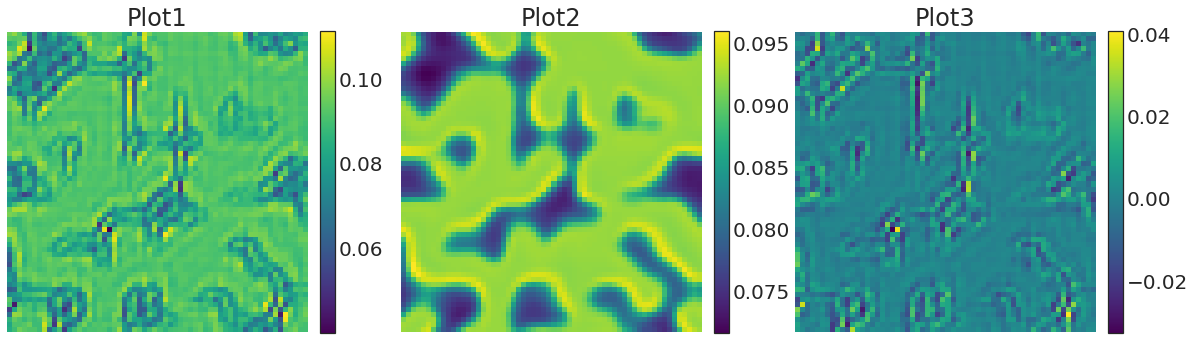

In [53]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

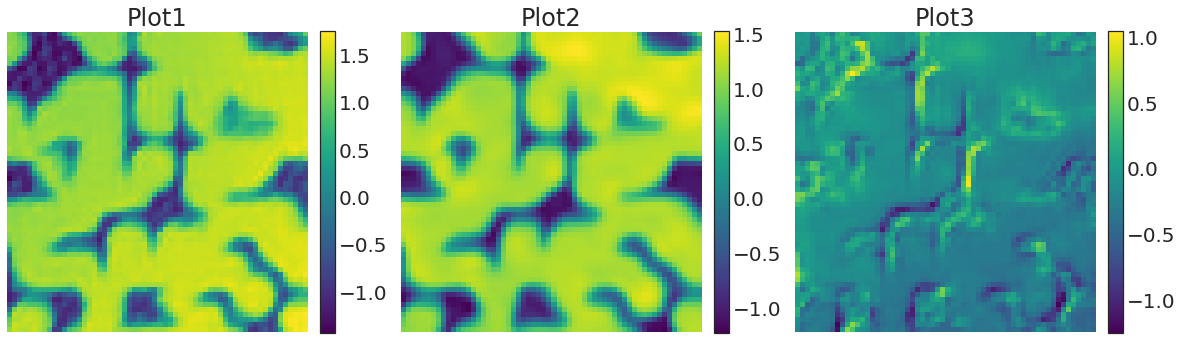

In [54]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [55]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  4.846189154578089e-05
MSE in phase:  0.08644169655817348


In [56]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [57]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.24462157095581727, -8.547854361633408e-17)